# Make Predictions with Linear Regression
This notebook shows how to perform linear regression on [Boston Housing Dataset](https://lib.stat.cmu.edu/datasets/boston).



In [1]:
# import packages
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
import pandas as pd
import io
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [2]:
# Suppress SSL warnings
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

# URL of the dataset
url = 'https://lib.stat.cmu.edu/datasets/boston'

# Send a GET request to the URL with SSL verification disabled
response = requests.get(url, verify=False)

In [3]:
dataset_content = response.text

In [4]:
# Create a DataFrame from the CSV text
df = pd.read_csv(io.StringIO(dataset_content),  sep='\s+', skiprows=22, header=None)
df.head(2)

,0,1,2,3,4,5,6,7,8,9,10
0,0.00632,18.00,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3
1,396.90000,4.98,24.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looks like some of the first row data has been tranferred to 2nd row and same pattern observed to all the even rows and name of the columns are missing.

In [5]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO','B','LSTAT','MEDV']

In [6]:
# Process the DataFrame to rearrange the rows
processed_data = []

In [7]:
for i in range(0, len(df), 2):
    if i + 1 < len(df):
    # Combine the standard columns
        data_row = df.iloc[i, :11].tolist()
        # Combine the columns from the next row intended for 'B', 'LSTAT', 'MEDV'
        additional_data = df.iloc[i + 1, :3].tolist()  # Assuming the misaligned data is at the start of the row
        full_row = data_row + additional_data
        processed_data.append(full_row)
# Create a new DataFrame with the correct structure
processed_df = pd.DataFrame(processed_data, columns=column_names)

In [8]:
processed_df.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6


In [9]:
processed_df.tail(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


 Variables in order:
 
 - CRIM     per capita crime rate by town
 - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
 - INDUS    proportion of non-retail business acres per town
 - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 - NOX      nitric oxides concentration (parts per 10 million)
 - RM       average number of rooms per dwelling
 - AGE      proportion of owner-occupied units built prior to 1940
 - DIS      weighted distances to five Boston employment centres
 - RAD      index of accessibility to radial highways
 - TAX      full-value property-tax rate per 10,000 dollars
 - PTRATIO  pupil-teacher ratio by town
 - B        1000(Bk - 0.63)\^2 where Bk is the proportion of blacks by town
 - LSTAT    % lower status of the population
 - MEDV     Median value of owner-occupied homes in 1000 dollars


Since we are trying to find out the housing price, MEDV definitely output and the rest is independent variables.

In [8]:
# Splitting the data into X and y
input_cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
output_col = ['MEDV']
X = processed_df[input_cols]
y = processed_df[output_col]

# Split the data into training and test data
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.30, random_state= 42)

Let`s do some relationship analysis between the predictor variables and the target variable(MEDV). 

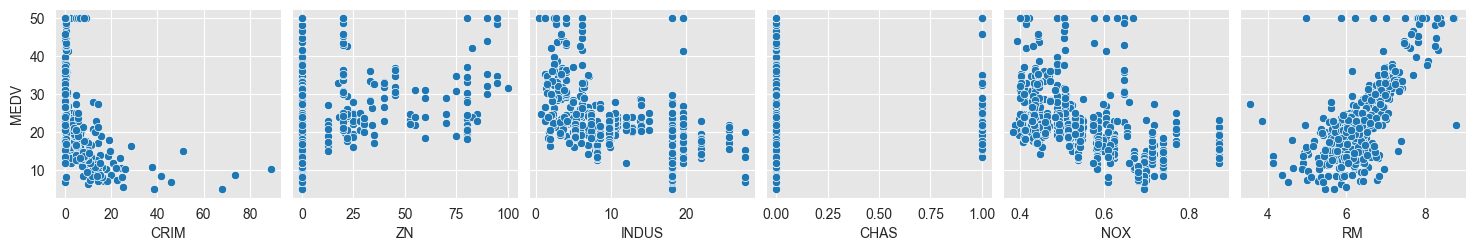

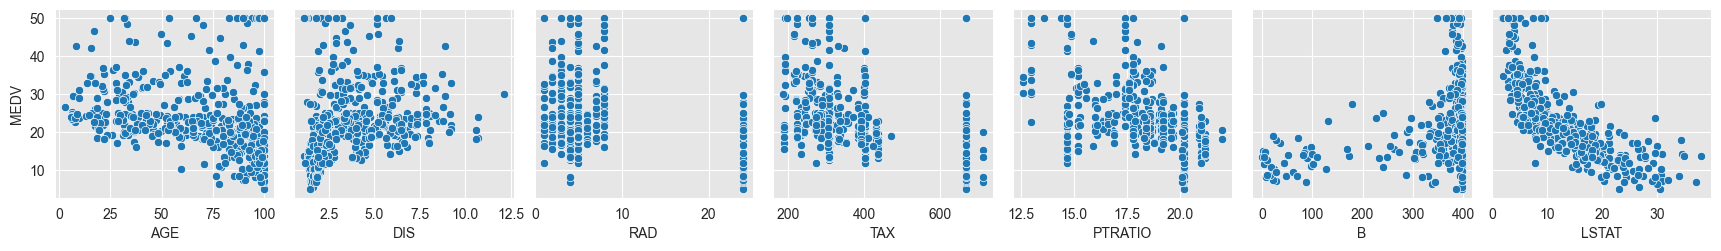

In [9]:
# Making two figures so it is better visualized
half = len(input_cols)//2

fig1=sns.pairplot(
    processed_df,
    x_vars=input_cols[:half],
    y_vars=output_col
)

fig2=sns.pairplot(
    processed_df,
    x_vars=input_cols[half:],
    y_vars=output_col
)

Here's what we can interpret from the pairplots:

- CRIM: There seems to be a negative relationship between crime rate and median home value — as crime rate increases, the home value tends to decrease.

- ZN: Its not very clear, but there might be a slight positive trend indicating that larger lot sizes (more residential zoning) may correspond to higher home values.

- INDUS: As the proportion of non-retail business acres increases, median home value seems to decrease, suggesting a preference for residential or mixed-use areas.
                                                                                                                               
- CHAS: The variable indicates if the property bounds the Charles River or not. While its a categorical variable and less clear in this scatter plot, properties on the river may have a higher median value.
    
- NOX: An increase in nitric oxides concentration tends to correlate with a decrease in home values, which could reflect the negative impact of pollution.

- RM: There is a strong positive correlation between the average number of rooms per dwelling and the median home value. More rooms typically mean a higher value.

- AGE: Older, owner-occupied units seem to have a lower median home value, indicating a potential preference for newer homes.
                                                                                                            
- DIS: There appears to be a positive correlation between weighted distances to employment centres and median home value, suggesting that proximity to work is valued.

- RAD: Theres no clear trend visible. RAD is an index of highway accessibility, and its relationship with MEDV may not be linear or may be influenced by other factors.

- TAX: Higher property tax rates dont show a clear relationship with home values, but there seems to be a clustering of data points with lower median values at the higher tax rate end.
    
- PTRATIO: There seems to be a slight negative correlation where higher pupil-teacher ratios might correspond with lower home values.

- B: The scatter plot is not very informative due to the transformation in the variable, but lower proportions of black residents might be correlated with higher home values, which could be indicative of socioeconomic disparities.

- LSTAT: There is a strong negative correlation; as the percentage of lower-status population increases, median home value tends to decrease.

- MEDV: The histogram of MEDV shows the distribution of median home values, with a concentration between approximately 20,000 and 25,000.

In [10]:
# Function to flatten 2D lists so it can be used by plotly
def flatten(l):
    return [item for sublist in l for item in sublist]

# Set up and fit the linear regressor
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Flatten the prediction and expected lists
predicted = flatten(lin_reg.predict(X_test))
expected = flatten(y_test.values)

In [12]:
import plotly.express as px
import plotly.graph_objects as go

# Assuming 'expected' and 'predicted' are lists or Pandas Series
df_plot = pd.DataFrame({'expected': expected, 'predicted': predicted})

# Make scatter plot from data
fig = px.scatter(
    df_plot, 
    x='expected', 
    y='predicted',
    title='Predicted vs. Actual Values',
    labels={'predicted': 'Predicted', 'expected': 'Expected'},  # Adding label for legend
    opacity=0.65  # Setting opacity to make plot clearer
)

# Add straight line indicating perfect model
fig.add_shape(type="line",
    x0=df_plot['expected'].min(), y0=df_plot['expected'].min(), 
    x1=df_plot['expected'].max(), y1=df_plot['expected'].max(),
    line=dict(
        color="Red",
        width=3,
        dash="dot",
    )
)

# Annotate the red line to add it to the legend
fig.add_trace(
    go.Scatter(
        x=[df_plot['expected'].min(), df_plot['expected'].max()],
        y=[df_plot['expected'].min(), df_plot['expected'].max()],
        name='Perfect Prediction',
        mode='lines',
        line=dict(color="Red", width=3, dash="dot"),
        showlegend=True
    )
)

# Update layout to add legend
fig.update_layout(
    legend_title_text='Legend',  # Title for the legend
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

# Show figure
fig.show(renderer='iframe')


While most data points are close to the "perfect prediction" line (the red dashed line), there's noticeable variance, especially with higher expected values. This suggests that while the model is relatively predictive, it's not perfect and has room for improvement.

In [14]:
# Print the root mean square error (RMS)
error = np.sqrt(np.mean((np.array(predicted) - np.array(expected)) ** 2))
print(f"RMS: {error:.4f} ")

r2=r2_score(expected, predicted)
print(f"R2: {round(r2,4)}") 

RMS: 4.6387 
R2: 0.7112


- RMSE (Root Mean Square Error) of 4.6387: This value indicates the model's typical error magnitude in the same units as the predicted value. An RMSE of 4.6387 means that, on average, the model's predictions are off by about 4.6387 units from the actual values.
- R2 (R-squared) of 0.7112: An R2 of 0.7112 suggests that approximately 71.12% of the variance in the dependent variable is predictable from the independent variables. This is a moderately good fit, meaning that the model explains a significant portion of the variability in the data but not all.

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

# Instantiate the linear regression model
lin_reg = LinearRegression()

# Set up cross-validation (K-Fold)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
# We'll use negative mean squared error as our scoring method and convert it to RMSE
neg_mse_cv_scores = cross_val_score(lin_reg, X, y, scoring='neg_mean_squared_error', cv=kfold)
rmse_cv_scores = np.sqrt(-neg_mse_cv_scores)

# Calculate mean RMSE and standard deviation across all folds
mean_rmse_cv = np.mean(rmse_cv_scores)
std_rmse_cv = np.std(rmse_cv_scores)

# Perform cross-validation for R^2
r2_cv_scores = cross_val_score(lin_reg, X, y, scoring='r2', cv=kfold)

# Calculate mean and standard deviation for R^2
mean_r2_cv = np.mean(r2_cv_scores)
std_r2_cv = np.std(r2_cv_scores)

print(f"Cross-Validated RMSE: {mean_rmse_cv} (±{std_rmse_cv})")
print(f"Cross-Validated R^2: {mean_r2_cv} (±{std_r2_cv})")


Cross-Validated RMSE: 4.842789010984499 (±0.18971102513142732)
Cross-Validated R^2: 0.7152218388256883 (±0.037466502855696075)


The cross-validated results reinforce the R2 score's indication of a stable model performance, and the slight increase in RMSE suggests that the model's performance is fairly reliable even when tested on different data subsets.

Overall, the model is reasonably good but not exceptional. To improve it, we might consider feature engineering, model complexity adjustment, or using a different modeling approach.